# 使用celeba数据集训练GAN

In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from CelebA import CelebADataset as CA

# GPU usage #########################################
# dtype = torch.FloatTensor # uncomment if you are using CPU
dtype = torch.cuda.FloatTensor # uncomment if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(3)


In [2]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)
    

# 鉴别器

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
                        View(218*178*3),

                        nn.Linear(218*178*3, 200),
                        # nn.Sigmoid(),
                        nn.LeakyReLU(0.02),

                        nn.LayerNorm(200),

                        nn.Linear(200, 1),
                        nn.Sigmoid()
        ).type(dtype)

        # 创建损失函数
        # self.loss_function = nn.MSELoss()
        self.loss_function = nn.BCELoss()

        # 创建优化器, 使用随机梯度下降
        # self.optimiser = torch.optim.SGD(self.parameters(), 
        #                                     lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), 
                                            lr=0.0001)

        # 计数器和进程记录
        self.counter = 0
        self.progress = []
                
    def forward(self,inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.model(inputs)
        
        # 计算损失值
        loss = self.loss_function(outputs, targets)
        
        # 每训练10次增加计数器
        if (self.counter % 10 == 0):    self.progress.append(loss.item())

        # if (self.counter % 10000 == 0): print("counter = ", self.counter)

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1

    def plot_progress(self):
        plt.scatter(np.arange(1, int(self.counter/10)+1),self.progress,s=10,c="tab:pink",label="Discriminator loss")
        plt.xlabel("time/10") 
        plt.ylabel("loss")
        
        plt.show()

# 生成器

In [4]:
class Generator(nn.Module):
    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()
        
         # 定义神经网络层
        self.model = nn.Sequential(
                        nn.Linear(100, 300),
                        # nn.Sigmoid(),
                        nn.LeakyReLU(0.02),

                        nn.LayerNorm(300),
                            
                        nn.Linear(300, 218*178*3),
                        nn.Sigmoid(),
                        
                        View((218,178,3))
        ).type(dtype)

        # 创建优化器，使用随机梯度下降
        # self.optimiser = torch.optim.SGD(self.parameters(), 
        #                                     lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), 
                                            lr=0.0001)
        
        # 计数器和进程记录
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)
        
    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)

        # 输入鉴别器
        d_output = D.forward(g_output)

        # 计算损失值
        loss = D.loss_function(d_output, targets)

        # 每训练10次增加计数器
        if (self.counter % 10 == 0):    self.progress.append(loss.item())

        if (self.counter % 5000 == 0): print("counter = ", self.counter)

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1

    def plot_progress(self):
        plt.scatter(np.arange(1, int(self.counter/10)+1),self.progress,s=10,c="tab:pink",label="Generator loss")
        plt.xlabel("time/10") 
        plt.ylabel("loss")
        
        plt.show()

    def plot_image(self, inputs):
        # 计算网络输出
        g_output = self.forward(inputs)
        g_output = np.array(g_output.detach().cpu()).reshape(218,178,3)
        figure, ax = plt.subplots()
        im = ax.imshow(g_output)
        plt.colorbar(im)
        plt.title('image of Generator')
        plt.show()

    def plot_image6(self, inputs):
        figure, ax = plt.subplots(2,3,figsize=(16,8))
        for i in range(2):
            for j in range(3):
                g_output = self.forward(inputs())
                g_output = np.array(g_output.detach().cpu()).reshape(218,178,3)
                ax[i,j].imshow(g_output,interpolation='none',cmap='Blues')
   

In [5]:
# 创建生成器和鉴别器
D = Discriminator()
G = Generator()

In [6]:
def generate_random_norm(size=100):
    random_data = torch.randn(size).type(dtype)
    return random_data

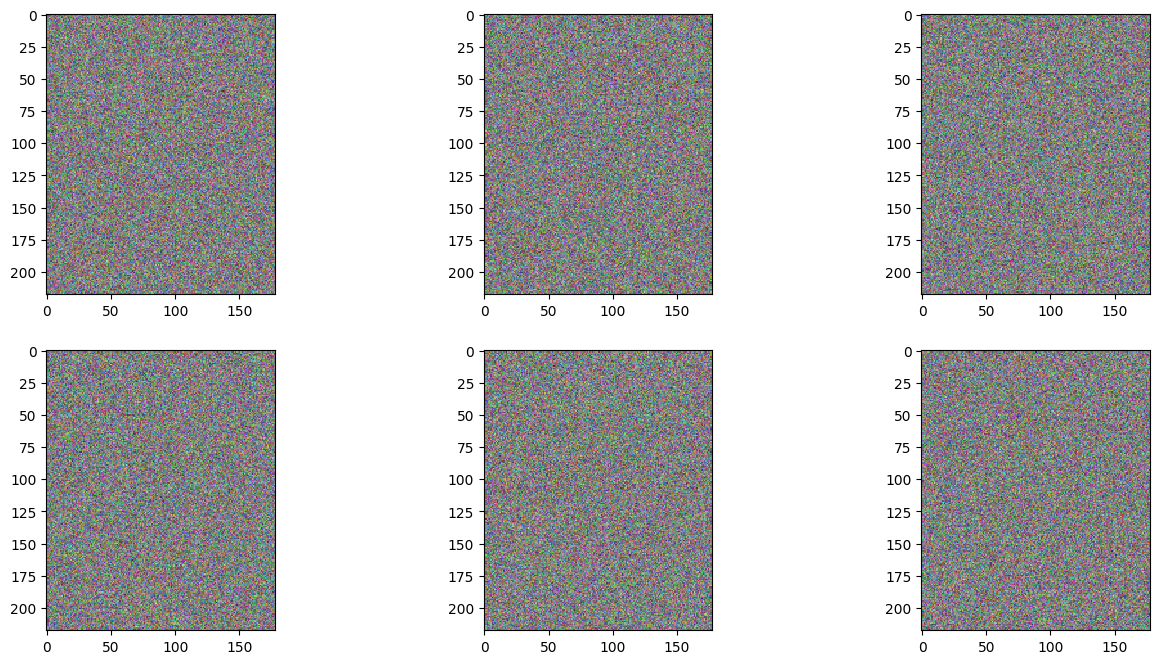

In [7]:
G.plot_image6(generate_random_norm)

In [8]:
file = r".//celeba//celeba_aligned_small.h5py"
CelebA = CA(file)

导入数据集


In [9]:
epochs = 1
right_lalel = torch.FloatTensor([1.0]).type(dtype)
error_lalel = torch.FloatTensor([0.0]).type(dtype)
for epoch in range(epochs):
    print ("epoch = ", epoch + 1)
    for im in CelebA:
        # 正确值
        D.train(im.type(dtype), right_lalel)      
        # 用生成器生成的数据训练鉴别器（错误 0.0）
        D.train(G.forward(generate_random_norm()).detach(), error_lalel)
        # 用生成器生成的数据训练生成器(正确 1.0）
        G.train(D, generate_random_norm(), right_lalel)


epoch =  1
counter =  0
counter =  5000
counter =  10000
counter =  15000


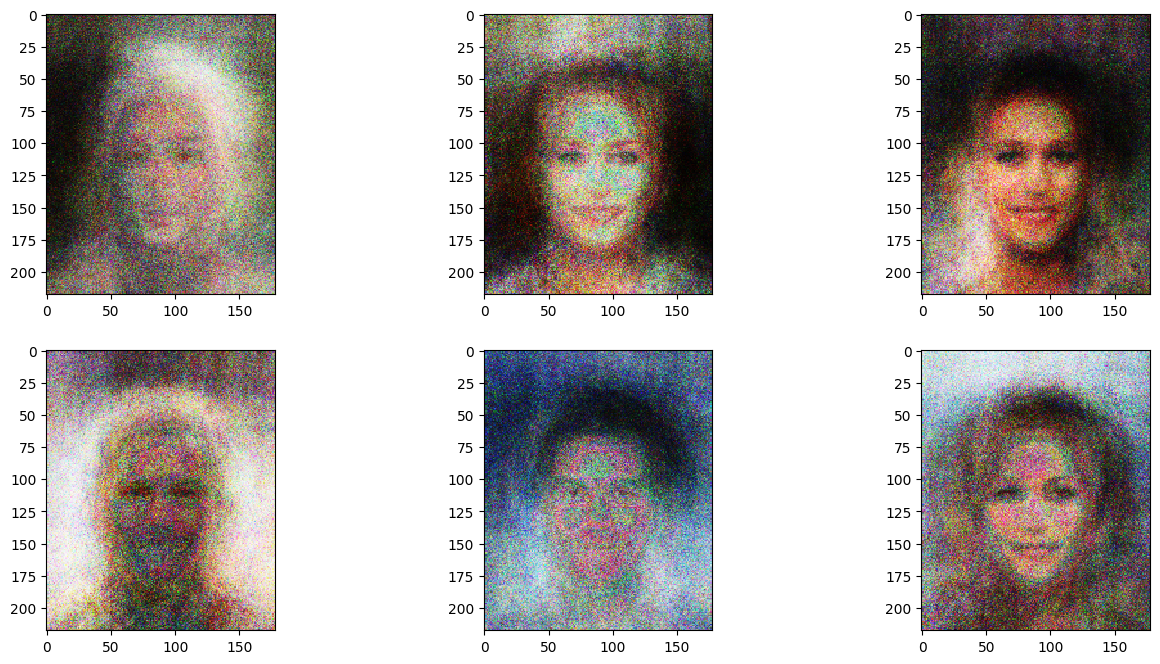

In [10]:
G.plot_image6(generate_random_norm)